# Papildomas darbas - Pair Trading

Prekiautojas turėtų ieškoti divergencijos porų, kurios nutolo viena nuo kitos, o paskui vėl susijungė pagal taisyklingą modelį.

Surandi akcijų porą, kuri turi judėti panašiai, pvz BP ir XOM akcijos. Abi yra didelės naftos gavybos įmonės.

https://www.contracts-for-difference.com/Contract-for-difference.html \\

https://blog.roboforex.com/blog/2021/05/27/what-is-pairs-trading-and-how-to-use-it/

**Darbą atliko:** Evelina Vaitkevičiūtė, DM 3k. 1gr.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import yfinance as yf


## Kointegruotos (Cointegrated) poros



Statistically speaking, they should have a high positive correlation coefficient.

The correlation coefficient measures the strength of the relationship between two stocks.

Finally, if the result is close to zero, it means that the two don’t have any relationship. As such, it is almost impossible to pairs trade when the result is zero.

[*********************100%%**********************]  11 of 11 completed


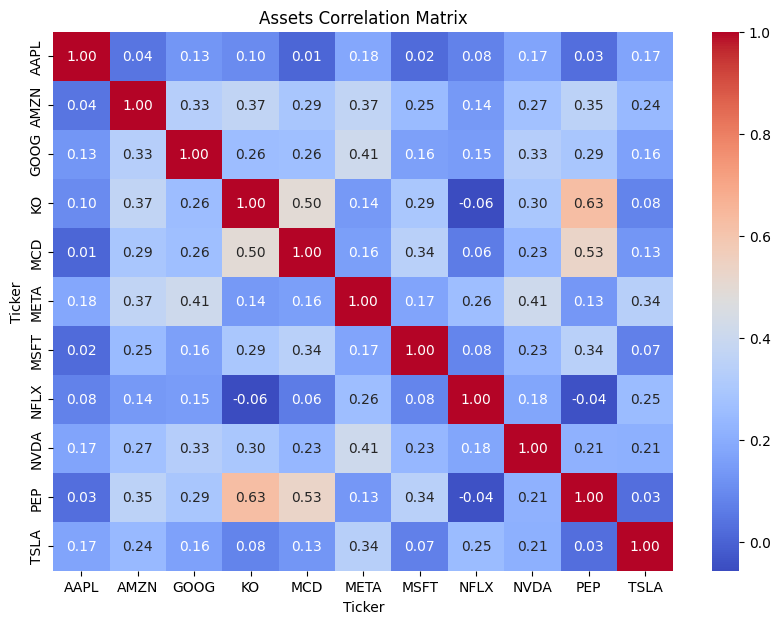

In [ ]:
symbols = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'KO', 'PEP', 'MCD']

data = yf.download(symbols, start="2013-10-01", end="2014-03-01")['Adj Close']

data = data.dropna()

# Daily returns
returns = data.pct_change().dropna()

# Pearson koreliacija
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(returns.corr(method='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
ax.set_title('Assets Correlation Matrix')

plt.show()


In [ ]:
start_date = '2013-10-01'
end_date = '2014-03-01'
ko = yf.download('KO', start=start_date, end=end_date)
pep = yf.download('PEP', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Pair trading strategija

In [ ]:
def download_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

def normalize_data(data):
    data = data['Close'].pct_change().dropna().cumsum() * 100
    return data

def calculate_spread(ko_data, pep_data):
    spread = ko_data - pep_data
    spread_mean = spread.mean()
    spread_std = spread.std()
    upper_threshold = spread_mean + spread_std
    lower_threshold = spread_mean - spread_std
    return spread, spread_mean, spread_std, upper_threshold, lower_threshold

def generate_signals(spread, ko_data, pep_data, spread_mean, spread_std, upper_threshold, lower_threshold):
    signals = pd.DataFrame(index=spread.index)
    signals['spread'] = spread
    signals['long_ko'] = 0
    signals['short_ko'] = 0
    signals['close'] = 0

    long_position = False
    short_position = False

    for i in range(1, len(spread)):
        if spread[i] > upper_threshold and not short_position:
            if ko_data[i] > ko_data[i-1] and pep_data[i] < pep_data[i-1]:  # KO is growing and PEP is decreasing
                signals.at[spread.index[i], 'short_ko'] = 1  # Short KO, Long PEP
                short_position = True
        elif spread[i] < lower_threshold and not long_position:
            if ko_data[i] < ko_data[i-1] and pep_data[i] > pep_data[i-1]:  # KO is decreasing and PEP is growing
                signals.at[spread.index[i], 'long_ko'] = 1  # Long KO, Short PEP
                long_position = True
        elif abs(spread[i] - spread_mean) < 0.1 * spread_std:
            if long_position or short_position:
                signals.at[spread.index[i], 'close'] = 1  # Close positions
                long_position = False
                short_position = False
    return signals


## Profit (pelnas)

In [ ]:
def calculate_profit(signals, ko_data, pep_data):
    profit = pd.Series(0, index=signals.index)
    long_position = short_position = 0

    for i in range(1, len(signals)):
        if signals['long_ko'][i] == 1:
            long_position = ko_data[i]
            short_position = pep_data[i]
        elif signals['short_ko'][i] == 1:
            long_position = -ko_data[i]
            short_position = -pep_data[i]
        elif signals['close'][i] == 1:
            if long_position != 0:
                profit[i] = (ko_data[i] - long_position) + (short_position - pep_data[i])
            elif short_position != 0:
                profit[i] = (-ko_data[i] - long_position) + (pep_data[i] - short_position)
            long_position = short_position = 0

    cumulative_profit = profit.cumsum()
    return cumulative_profit

## Kainų ir stacionarumo (spread) grafikai

In [ ]:
def plot_price_and_spread(ko_data, pep_data, signals, spread, spread_mean, upper_threshold, lower_threshold):
    fig, axs = plt.subplots(2, figsize=(14, 10), sharex=True)

    # Price plot
    axs[0].plot(ko_data.index, ko_data, label='KO Normalized', color='royalblue')
    axs[0].plot(pep_data.index, pep_data, label='PEP Normalized', color='seagreen')
    axs[0].set_ylabel('Normalized Price (%)')
    axs[0].legend()
    axs[0].grid(True)

    long_indices = signals.index[signals['long_ko'] == 1]
    short_indices = signals.index[signals['short_ko'] == 1]
    close_indices = signals.index[signals['close'] == 1]

    if len(long_indices) > 0:
        axs[0].plot(long_indices, ko_data[signals['long_ko'] == 1], '^', markersize=10, color='green', label='Long KO / Short PEP')
    if len(short_indices) > 0:
        axs[0].plot(short_indices, ko_data[signals['short_ko'] == 1], 'v', markersize=10, color='red', label='Short KO / Long PEP')
    if len(close_indices) > 0:
        axs[0].plot(close_indices, ko_data[signals['close'] == 1], 'o', markersize=15, color='gray', alpha=0.7, label='Close Position')

    axs[0].legend(loc='upper left')
    axs[0].set_title('Pairs Trading Strategy for KO and PEP')

    # Spread visualization
    axs[1].plot(spread.index, spread, label='Spread', color='green', linestyle='--')
    axs[1].axhline(y=spread_mean, color='black', linestyle='-', label='Spread Mean')
    axs[1].set_ylabel('Spread')
    axs[1].axhline(y=upper_threshold, color='r', linestyle='--', label='Upper Threshold')
    axs[1].axhline(y=lower_threshold, color='b', linestyle='--', label='Lower Threshold')

    if len(long_indices) > 0:
        axs[1].plot(long_indices, spread[signals['long_ko'] == 1], '^', markersize=10, color='green', label='Long KO / Short PEP')
    if len(short_indices) > 0:
        axs[1].plot(short_indices, spread[signals['short_ko'] == 1], 'v', markersize=10, color='red', label='Short KO / Long PEP')
    if len(close_indices) > 0:
        axs[1].plot(close_indices, spread[signals['close'] == 1], 'o', markersize=15, color='gray', alpha=0.7, label='Close Position')

    axs[1].legend(loc='upper left')
    axs[1].set_xlabel('Date')

    plt.show()

## Profit grafikas

In [ ]:
def plot_cumulative_profit(cumulative_profit):
    plt.figure(figsize=(14, 4))
    plt.plot(cumulative_profit.index, cumulative_profit, label='Cumulative Profit', color='purple')
    plt.ylabel('Cumulative Profit')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Date')
    plt.title('Cumulative Profit of Pairs Trading Strategy')
    plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


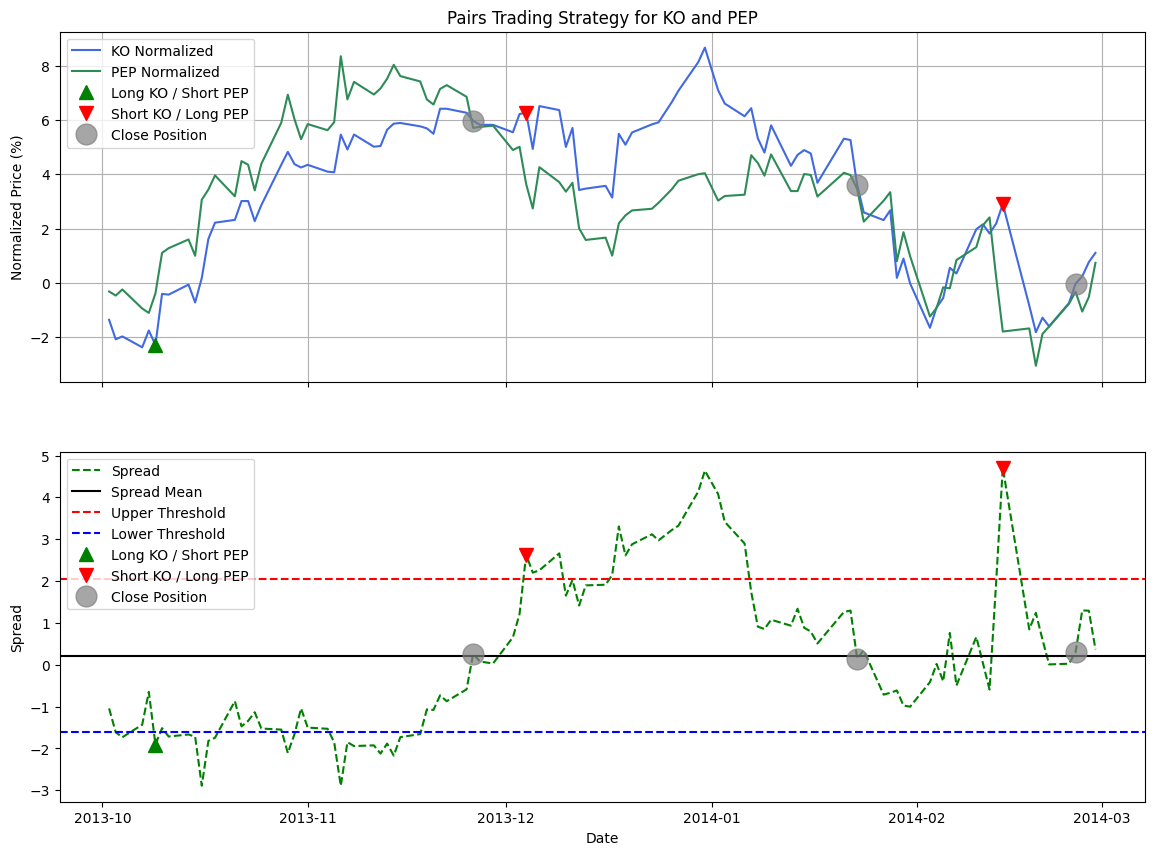

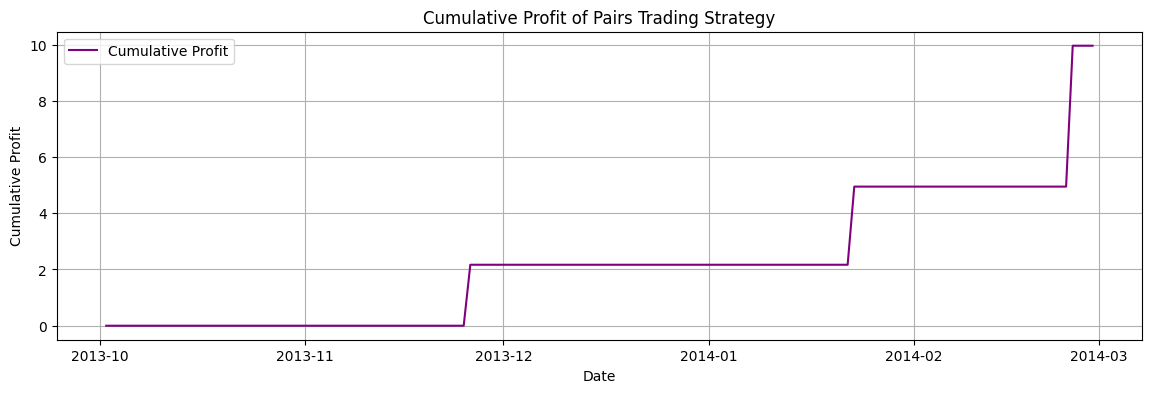

In [ ]:
def main():
    start_date = '2013-10-01'
    end_date = '2014-03-01'

    ko = download_data('KO', start_date, end_date)
    pep = download_data('PEP', start_date, end_date)

    ko_data = normalize_data(ko)
    pep_data = normalize_data(pep)

    spread, spread_mean, spread_std, upper_threshold, lower_threshold = calculate_spread(ko_data, pep_data)

    signals = generate_signals(spread, ko_data, pep_data, spread_mean, spread_std, upper_threshold, lower_threshold)

    cumulative_profit = calculate_profit(signals, ko_data, pep_data)

    plot_price_and_spread(ko_data, pep_data, signals, spread, spread_mean, upper_threshold, lower_threshold)
    plot_cumulative_profit(cumulative_profit)

if __name__ == "__main__":
    main()

## Kita strategija

[*********************100%%**********************]  8 of 8 completed


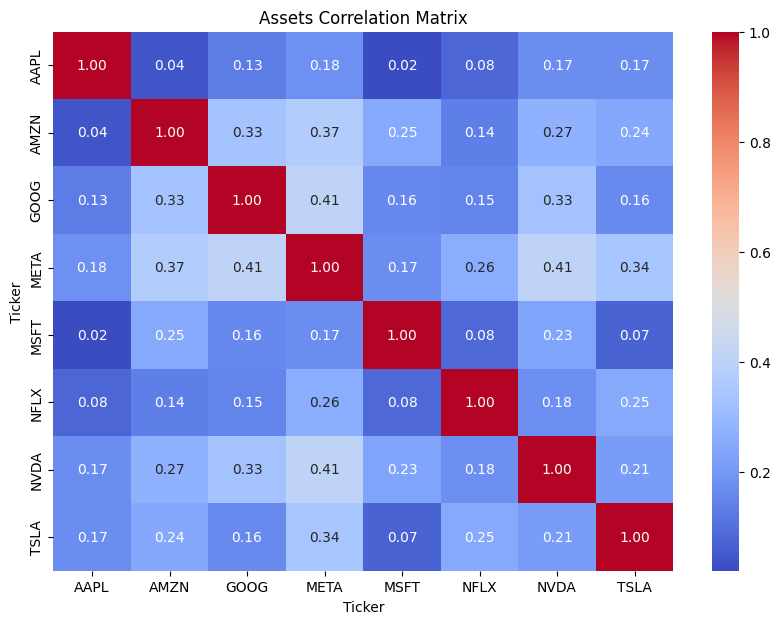

In [ ]:
symbols = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA']

data = yf.download(symbols, start="2013-10-01", end="2014-03-01")['Adj Close']

data = data.dropna()

# Daily returns
returns = data.pct_change().dropna()

# Pearson koreliacija
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(returns.corr(method='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
ax.set_title('Assets Correlation Matrix')

plt.show()

# def find_cointegrated_pairs(data):
#     n = data.shape[1]
#     pvalue_matrix = np.ones((n, n))
#     keys = data.columns
#     pairs = []
#     for i in range(n):
#         for j in range(i + 1, n):
#             stock1 = data[keys[i]].dropna()
#             stock2 = data[keys[j]].dropna()
#             if len(stock1) == len(stock2):
#                 result = coint(stock1, stock2)
#                 pvalue_matrix[i, j] = result[1]
#                 if result[1] < 0.05:
#                     pairs.append((keys[i], keys[j]))
#             else:
#                 combined_data = pd.concat([stock1, stock2], axis=1).dropna()
#                 if not combined_data.empty:
#                     result = coint(combined_data.iloc[:, 0], combined_data.iloc[:, 1])
#                     pvalue_matrix[i, j] = result[1]
#                     if result[1] < 0.05:
#                         pairs.append((keys[i], keys[j]))
#     return pvalue_matrix, pairs

# pvalues, pairs = find_cointegrated_pairs(data)
# print(pairs)
# fig, ax = plt.subplots(figsize=(10, 7))
# sns.heatmap(pvalues, xticklabels=data.columns, yticklabels=data.columns, cmap='RdYlGn_r', annot=True, fmt=".2f", mask=(pvalues >= 0.99))
# ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
# plt.tight_layout()
# plt.show()


# p reikšmė mažesnė nei 0,05. Tai reiškia, kad šių porų atveju galime atmesti nulinę hipotezę ir jos gali būti kointegruotos (cointegrated).

# Pora - AAPL ir MSFT
# Kad mūsų strategija būtų pelninga, jos turi skirtis ir vidutiniškai keistis.


## Stacionarumo testas

Svarbu, kad sklaida būtų stacionari.

Sklaidos stacionarumas tikrinamas naudojant Augmented Dickey-Fuller test Laiko eilutė laikoma stacionaria, jei tokie parametrai kaip vidurkis ir dispersija laikui bėgant nekinta ir nėra vienetinės šaknies.

Pirmiausia apskaičiuosime šių dviejų porų apsidraudimo santykį, taikydami OLS tiesinę regresiją. Tada, naudodami apsidraudimo santykį, apskaičiuosime sklaidą ir atliksime  Dickey-Fullerio testą.

Date
2022-01-03   -64.155253
2022-01-04   -64.800309
2022-01-05   -66.871373
2022-01-06   -63.033558
2022-01-07   -63.242957
                ...    
2023-12-22   -48.171938
2023-12-26   -46.895106
2023-12-27   -47.700579
2023-12-28   -47.430964
2023-12-29   -44.388315
Length: 501, dtype: float64


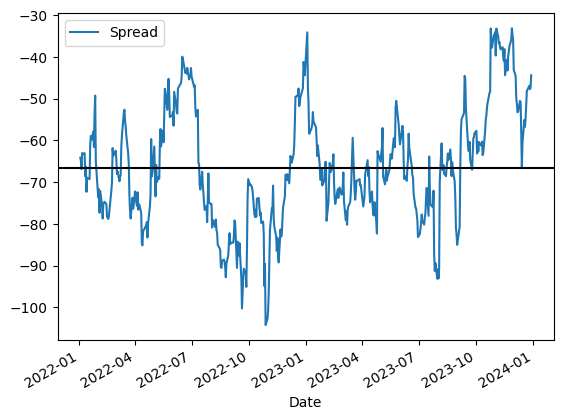

In [ ]:
stock1 = data.AAPL
stock2 = data.MSFT
stock1 = sm.add_constant(stock1)
results = sm.OLS(stock2, stock1).fit()
stock1 = stock1.AAPL
b = results.params['AAPL']
spread = stock2 - b * stock1
print(spread)

spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);


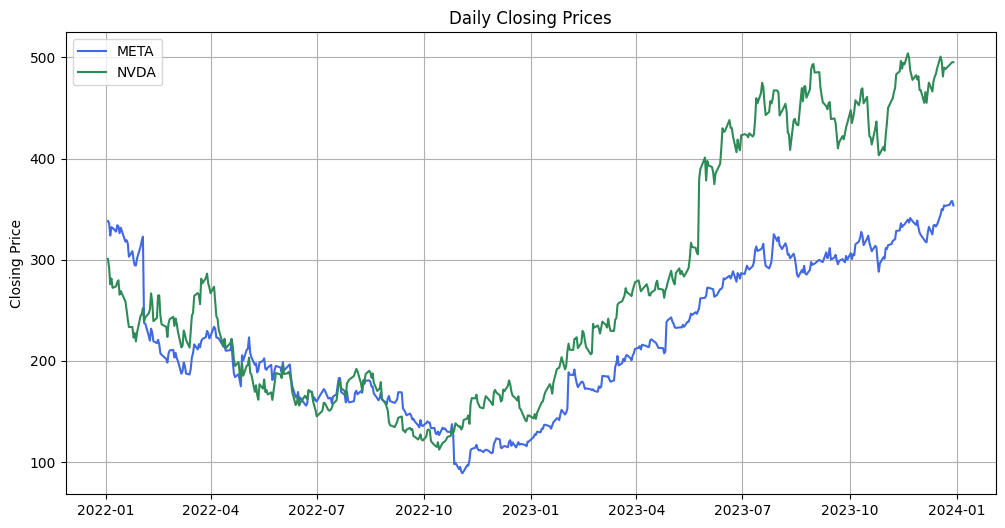

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     2351.
Date:                Wed, 22 May 2024   Prob (F-statistic):          5.95e-191
Time:                        13:53:41   Log-Likelihood:                -2682.0
No. Observations:                 501   AIC:                             5368.
Df Residuals:                     499   BIC:                             5376.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -63.3236      7.350     -8.615      0.0

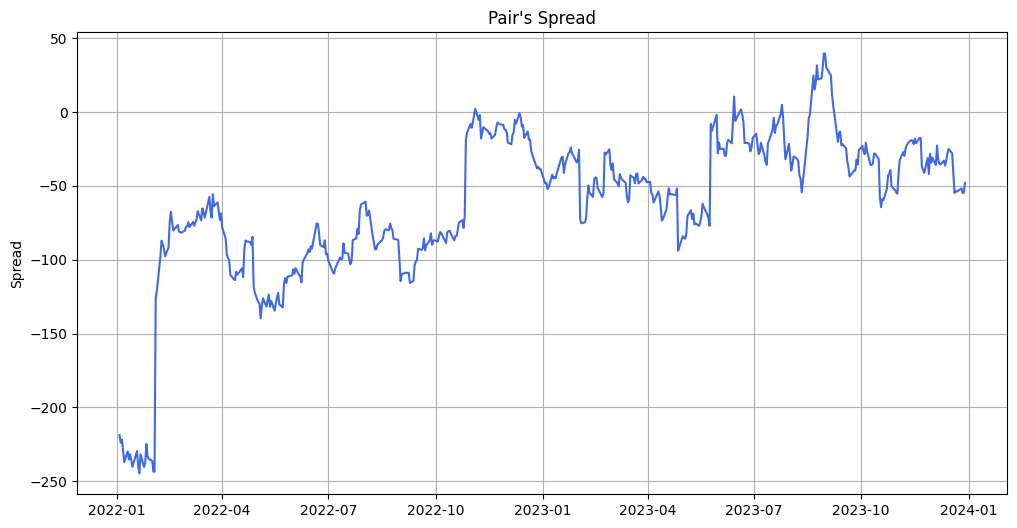

Critical Value =  -3.257869831286247
{'1%': -3.443496379464, '5%': -2.8673378563200003, '10%': -2.569858036}


In [ ]:
from statsmodels.tsa.stattools import adfuller

stock1 = data['META']
stock2 = data['NVDA']

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data['META'], label='META', color='royalblue',  linewidth=1.5)
ax.plot(data.index, data['NVDA'], label='NVDA', color='seagreen',  linewidth=1.5)
ax.set_ylabel("Closing Price")
ax.set_title('Daily Closing Prices')
ax.legend()
ax.grid(True)
plt.show()

# OLS regresija
model = sm.OLS(stock2, sm.add_constant(stock1)).fit()

print(model.summary())

print('Hedge Ratio = ', model.params['META'])

spread = stock2 - model.params['META'] * stock1


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, spread, color='royalblue')
ax.set_ylabel("Spread")
ax.set_title("Pair's Spread")
ax.grid(True)
plt.show()

# Augmented Dickey-Fuller testas
adf = adfuller(spread, maxlag=1)
print('Critical Value = ', adf[0])

# Kritinės reikšmės
print(adf[4])


Didelė R kvadrato vertė ir beveik nulinė p reikšmė OLS regresijoje rodo, kad šių dviejų akcijų koreliacija yra labai didelė.

Atrodo, kad skirtumas yra stacionarus, o **Dickey-Fullerio testo** kritinė reikšmė yra -3.257, t. y. mažesnė už 5 % (-2.867) reikšmingumo lygmens reikšmę. Taigi galime atmesti nulinę hipotezę, kad kainų skirtumas turi vienetinę šaknį, ir galime daryti išvadą, kad jis yra stacionarus.

## Signalai naudojant z-score (standartizuotą reikšmę)

Prekybos signalams generuoti naudosime dviejų akcijų kainų santykio z-score ir nustatysime viršutinę ir apatinę ribas. Tai parodys, kaip toli kaina yra nuo  vidutinės vertės.

Jei jis yra teigiamas ir reikšmė viršija viršutinę ribą, vadinasi, akcijų kaina yra didesnė už vidutinę kainos vertę. Todėl tikimasi, kad jos kaina mažės, todėl norime shortinti (parduoti) šią akciją ir longinti (pirkti) kitą.


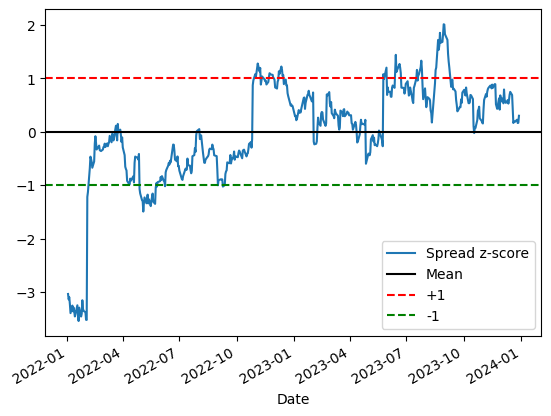

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

<Axes: xlabel='Date'>

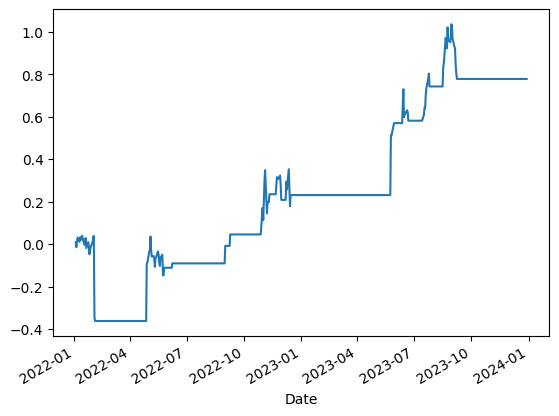

In [ ]:
trades = pd.concat([zscore(spread), stock2 - b * stock1], axis=1)
trades.columns = ["signal", "position"]

trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

# 1, kai signalas yra mažesnis arba lygus lower (-1), ir -1, kai signalas yra didesnis arba lygus upper (1).

returns = trades.position.pct_change() * trades.side
returns.cumsum().plot()

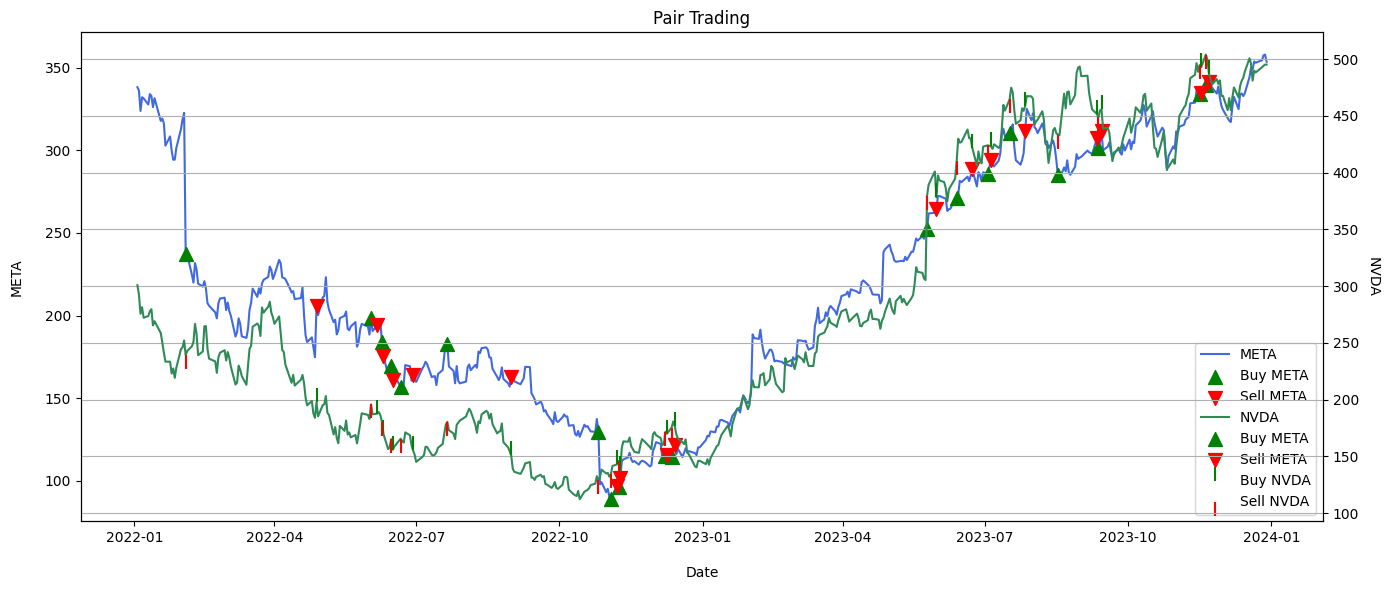

In [ ]:
asset1 = 'META'
asset2 = 'NVDA'

def zscore(series):
    return (series - series.mean()) / np.std(series)

def plot_signals(ax, signals, asset, positions, marker_up, marker_down, color='g'):
    long_positions = ax.scatter(signals.index[positions == 1],
                                signals[asset][positions == 1],
                                marker=marker_up, s=100, color=color, label=f'Buy {asset}', zorder=3)
    short_positions = ax.scatter(signals.index[positions == -1],
                                 signals[asset][positions == -1],
                                 marker=marker_down, s=100, color='r', label=f'Sell {asset}', zorder=3)
    return long_positions, short_positions

def pair_trading(asset1, asset2, stock1, stock2):
    signals = pd.DataFrame()
    signals[asset1] = stock1
    signals[asset2] = stock2

    ratios = signals[asset1] / signals[asset2]

    signals['z'] = zscore(ratios)
    signals['z_upper_limit'] = np.mean(signals['z']) + np.std(signals['z'])
    signals['z_lower_limit'] = np.mean(signals['z']) - np.std(signals['z'])

    signals['signals1'] = np.where(signals['z'] > signals['z_upper_limit'], -1,
                                   np.where(signals['z'] < signals['z_lower_limit'], 1, 0))
    signals['positions1'] = signals['signals1'].diff()
    signals['signals2'] = -signals['signals1']
    signals['positions2'] = signals['signals2'].diff()

    fig, ax = plt.subplots(figsize=(14, 6))
    ax2 = ax.twinx()

    asset1_line, = ax.plot(signals.index, signals[asset1], label=asset1, color='royalblue', zorder=2)
    asset2_line, = ax2.plot(signals.index, signals[asset2], label=asset2, color='seagreen', zorder=2)

    long_asset1, short_asset1 = plot_signals(ax, signals, asset1, signals['positions1'], '^', 'v')
    long_asset2, short_asset2 = plot_signals(ax2, signals, asset2, signals['positions2'], 2, 3)

    ax.set_ylabel(asset1)
    ax2.set_ylabel(asset2, rotation=270)
    ax.yaxis.labelpad = 15
    ax2.yaxis.labelpad = 15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad = 15

    handles, labels = ax.get_legend_handles_labels()
    handles += [asset2_line, long_asset1, short_asset1, long_asset2, short_asset2]
    labels += [asset2, f'Buy {asset1}', f'Sell {asset1}', f'Buy {asset2}', f'Sell {asset2}']

    ax.legend(handles, labels, loc='lower right')
    plt.title('Pair Trading')

    plt.tight_layout()
    plt.grid(True)
    plt.show()


pair_trading('META', 'NVDA', stock1, stock2)
